In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import os

In [3]:
from tqdm import tqdm

In [6]:
train = pd.read_table('snli/snli_1.0_train.txt', delimiter = '\t')

In [7]:
train.head()

,gold_label,sentence1_binary_parse,sentence2_binary_parse,sentence1_parse,sentence2_parse,sentence1,sentence2,captionID,pairID,label1,label2,label3,label4,label5
0,neutral,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( is ( ( training ( his horse...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,3416050480.jpg#4,3416050480.jpg#4r1n,neutral,NaN,NaN,NaN,NaN
1,contradiction,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,( ( A person ) ( ( ( ( is ( at ( a diner ) ) )...,(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",3416050480.jpg#4,3416050480.jpg#4r1c,contradiction,NaN,NaN,NaN,NaN
2,entailment,( ( ( A person ) ( on ( a horse ) ) ) ( ( jump...,"( ( A person ) ( ( ( ( is outdoors ) , ) ( on ...",(ROOT (S (NP (NP (DT A) (NN person)) (PP (IN o...,(ROOT (S (NP (DT A) (NN person)) (VP (VBZ is) ...,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",3416050480.jpg#4,3416050480.jpg#4r1e,entailment,NaN,NaN,NaN,NaN
3,neutral,( Children ( ( ( smiling and ) waving ) ( at c...,( They ( are ( smiling ( at ( their parents ) ...,(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (PRP They)) (VP (VBP are) (VP (VB...,Children smiling and waving at camera,They are smiling at their parents,2267923837.jpg#2,2267923837.jpg#2r1n,neutral,NaN,NaN,NaN,NaN
4,entailment,( Children ( ( ( smiling and ) waving ) ( at c...,( There ( ( are children ) present ) ),(ROOT (NP (S (NP (NNP Children)) (VP (VBG smil...,(ROOT (S (NP (EX There)) (VP (VBP are) (NP (NN...,Children smiling and waving at camera,There are children present,2267923837.jpg#2,2267923837.jpg#2r1e,entailment,NaN,NaN,NaN,NaN


In [8]:
premises = pd.DataFrame()
premises["sentence"] = train["sentence1"]

hypotheses = pd.DataFrame()
hypotheses["sentence"] = train["sentence2"]

In [9]:
premises.head()

,sentence
0,A person on a horse jumps over a broken down a...
1,A person on a horse jumps over a broken down a...
2,A person on a horse jumps over a broken down a...
3,Children smiling and waving at camera
4,Children smiling and waving at camera


In [10]:
hypotheses.head()

,sentence
0,A person is training his horse for a competition.
1,"A person is at a diner, ordering an omelette."
2,"A person is outdoors, on a horse."
3,They are smiling at their parents
4,There are children present


In [11]:
premises.describe()

,sentence
count,550152
unique,150736
top,A dog in a field.
freq,33


In [12]:
hypotheses.describe()

,sentence
count,550146
unique,480040
top,A man is sleeping.
freq,335


In [13]:
premises.drop_duplicates(inplace=True)
hypotheses.drop_duplicates(inplace=True)

In [14]:
premises.describe()

,sentence
count,150736
unique,150736
top,A person on a horse jumps over a broken down a...
freq,1


In [15]:
hypotheses.describe()

,sentence
count,480040
unique,480040
top,A person is training his horse for a competition.
freq,1


In [16]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
tokenizer = RegexpTokenizer('[a-z]\w+')

def preprocess(sentence):
    if isinstance(sentence, float):
        return []
    else:
        sentence = sentence.lower()
        tokenized = tokenizer.tokenize(sentence)
        return list(set([word for word in tokenized if word not in stop_words]))
    
preprocess('A person on a horse jumps over a broken down airplane.')

['person', 'airplane', 'jumps', 'horse', 'broken']

In [18]:
premises["sentence"] = premises["sentence"].map(preprocess)
hypotheses["sentence"] = hypotheses["sentence"].map(preprocess)

In [19]:
[i for i in premises.values[0]][0]

['person', 'airplane', 'jumps', 'horse', 'broken']

In [20]:
hypotheses.head()

,sentence
0,"[horse, person, competition, training]"
1,"[omelette, ordering, person, diner]"
2,"[outdoors, horse, person]"
3,"[smiling, parents]"
4,"[present, children]"


In [21]:
premise_dict = {}

for sentence in tqdm(premises.values):
    sentence = sentence[0]
    for word in sentence:
        premise_dict[word] = premise_dict.get(word, 0) + 1

100%|████████████████████████████████████████████████████████████████████████████████████| 150736/150736 [00:00<00:00, 488161.50it/s]


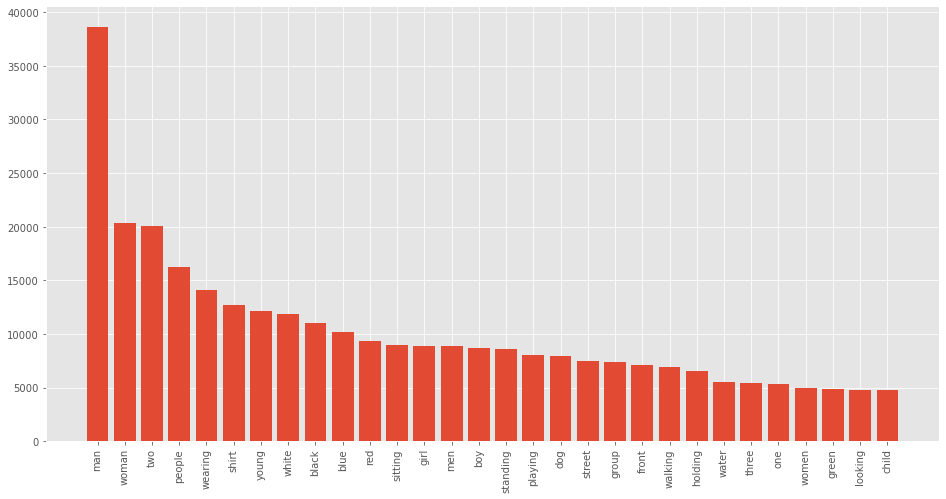

In [22]:
premise_dict_items = premise_dict.items()
premise_dict_items = sorted(premise_dict_items, key=lambda x: x[1], reverse=True)
topk = premise_dict_items[:30]
plt.figure(figsize=(16, 8))
plt.bar([x[0] for x in topk], [x[1] for x in topk])
plt.xticks(rotation=90)
plt.show()

In [23]:
hypothesis_dict = {}

for sentence in tqdm(hypotheses.values):
    sentence = sentence[0]
    for word in sentence:
        hypothesis_dict[word] = hypothesis_dict.get(word, 0) + 1

100%|████████████████████████████████████████████████████████████████████████████████████| 480041/480041 [00:00<00:00, 669967.27it/s]


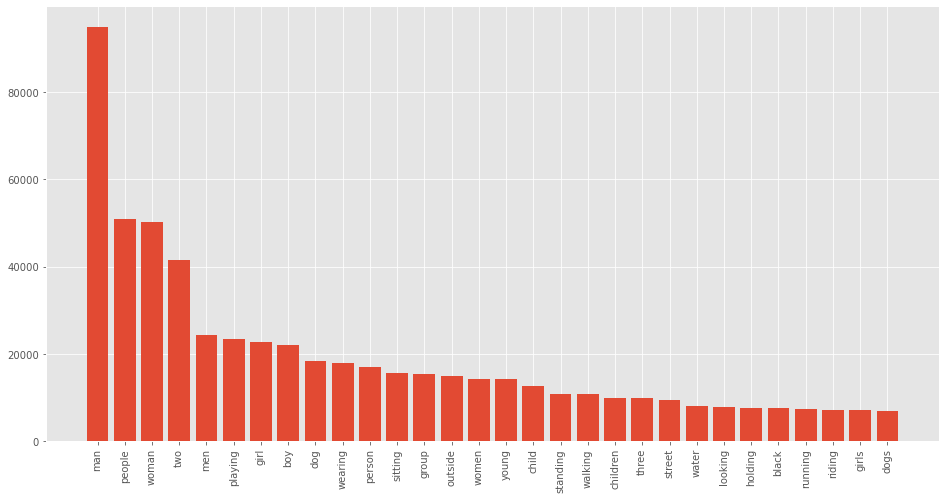

In [24]:
hypothesis_dict_items = hypothesis_dict.items()
hypothesis_dict_items = sorted(hypothesis_dict_items, key=lambda x: x[1], reverse=True)
topk = hypothesis_dict_items[:30]
plt.figure(figsize=(16, 8))
plt.bar([x[0] for x in topk], [x[1] for x in topk])
plt.xticks(rotation=90)
plt.show()

In [26]:
my_file = open('identity_labels.txt', "r")
content = my_file.read()
identities = content.split('\n')
identities[:10]

['woman', 'women', 'man', 'men', 'girl', 'girls', 'boy', 'boys', 'she', 'he']

In [27]:
identity_premise_dict = {}

for identity in tqdm(identities):
    for sentence in premises.values:
        sentence = sentence[0]
        if identity in sentence:
            identity_premise_dict[identity] = identity_premise_dict.get(identity, 0) + 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:06<00:00, 20.64it/s]


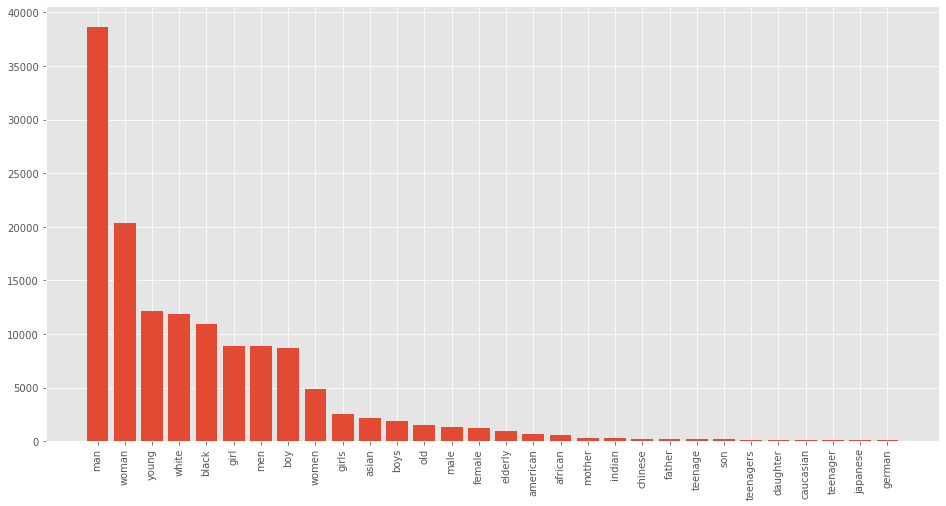

In [28]:
identity_premise_dict_items = identity_premise_dict.items()
identity_premise_dict_items = sorted(identity_premise_dict_items, key=lambda x: x[1], reverse=True)
topk = identity_premise_dict_items[:30]
plt.figure(figsize=(16, 8))
plt.bar([x[0] for x in topk], [x[1] for x in topk])
plt.xticks(rotation=90)
plt.show()

In [29]:
identity_hypothesis_dict = {}

for identity in tqdm(identities):
    for sentence in hypotheses.values:
        sentence = sentence[0]
        if identity in sentence:
            identity_hypothesis_dict[identity] = identity_hypothesis_dict.get(identity, 0) + 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:16<00:00,  7.74it/s]


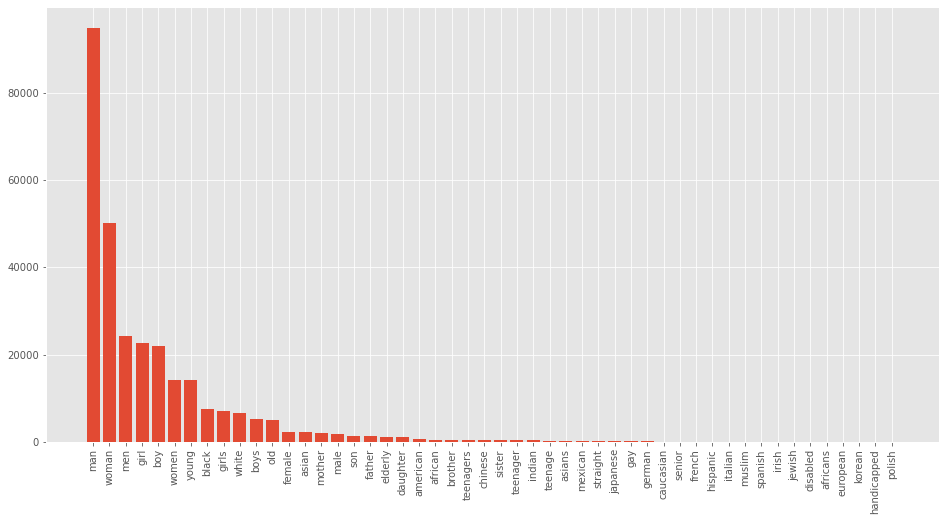

In [93]:
identity_hypothesis_dict_items = identity_hypothesis_dict.items()
identity_hypothesis_dict_items = sorted(identity_hypothesis_dict_items, key=lambda x: x[1], reverse=True)
topk = identity_hypothesis_dict_items[:50]
plt.figure(figsize=(16, 8))
plt.bar([x[0] for x in topk], [x[1] for x in topk])
plt.xticks(rotation=90)
plt.show()

In [40]:
i_p_dict = {}

for identity in tqdm(identities):
    for sentence in premises.values:
        sentence = sentence[0]
        if identity in sentence:
            for word in sentence:
                i_p_dict[(identity, word)] = i_p_dict.get((identity, word), 0) + 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:06<00:00, 19.51it/s]


In [41]:
list(i_p_dict.items())[:10]

[(('woman', 'man'), 4289),
 (('woman', 'woman'), 20325),
 (('woman', 'beach'), 320),
 (('woman', 'enjoying'), 70),
 (('woman', 'child'), 638),
 (('woman', 'street'), 1222),
 (('woman', 'restaurant'), 154),
 (('woman', 'front'), 1182),
 (('woman', 'gyro'), 2),
 (('woman', 'pizza'), 12)]

In [52]:
i_h_dict = {}

for identity in tqdm(identities):
    for sentence in hypotheses.values:
        sentence = sentence[0]
        if identity in sentence:
            for word in sentence:
                i_h_dict[(identity, word)] = i_h_dict.get((identity, word), 0) + 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:17<00:00,  7.48it/s]


In [43]:
list(i_h_dict.items())[:10]

[(('woman', 'woman'), 50214),
 (('woman', 'two'), 1135),
 (('woman', 'picture'), 557),
 (('woman', 'nake'), 1),
 (('woman', 'cold'), 63),
 (('woman', 'wearing'), 2802),
 (('woman', 'green'), 485),
 (('woman', 'white'), 874),
 (('woman', 'black'), 1151),
 (('woman', 'street'), 1073)]

# Counting PMI

In [47]:
PMI_premise = {}
N = len(premises.values)

for identity, premise in list(i_p_dict.keys()):
    c_wi = identity_premise_dict[identity]
    c_wj = premise_dict[premise]
    c_wi_wj = i_p_dict[(identity, premise)]
    
    PMI_premise[(identity, premise)] = np.log2((N * c_wi_wj) / (c_wi * c_wj))

In [49]:
len(PMI_premise)

82371

In [54]:
PMI_hypothesis = {}
N = len(hypotheses.values)

for identity, hyp in list(i_h_dict.keys()):
    c_wi = identity_hypothesis_dict[identity]
    c_wj = hypothesis_dict[hyp]
    c_wi_wj = i_h_dict[(identity, hyp)]
    
    PMI_hypothesis[(identity, hyp)] = np.log2((N * c_wi_wj) / (c_wi * c_wj))

In [55]:
len(PMI_hypothesis)

99132

# PMI Analysis

In [61]:
PMI_p = defaultdict(list)

for (identity, premise) in PMI_premise:
    PMI_p[identity].append((premise, PMI_premise[(identity, premise)]))

In [67]:
for identity in PMI_p:
    PMI_p[identity] = sorted(PMI_p[identity], key=lambda x: x[1], reverse=True)

In [94]:
[x[0] for x in PMI_p['asians'][:100]]

['asians',
 'motif',
 'anglo',
 'concepts',
 'od',
 'holidays',
 'cheerfully',
 'totem',
 'backdropped',
 'assignment',
 'napkin',
 'personal',
 'southeast',
 'receive',
 'assortment',
 'occupied',
 'kiddie',
 'shake',
 'leafy',
 'engage',
 'threw',
 'soup',
 'harvesting',
 'cafeteria',
 'unknown',
 'recording',
 'bundled',
 'characters',
 'studying',
 'contest',
 'presents',
 'cameras',
 'banner',
 'gymnasium',
 'discussing',
 'candles',
 'exercise',
 'vegetable',
 'pit',
 'sell',
 'squatting',
 'baskets',
 'celebrating',
 'traditional',
 'barbecue',
 'lunch',
 'vegetables',
 'lies',
 'funny',
 'poles',
 'eating',
 'appear',
 'pavement',
 'curb',
 'wear',
 'books',
 'marching',
 'drawing',
 'produce',
 'windows',
 'dinner',
 'relaxing',
 'eat',
 'happy',
 'passing',
 'classroom',
 'wait',
 'gathering',
 'market',
 'lit',
 'gathered',
 'basket',
 'desk',
 'staring',
 'gather',
 'look',
 'event',
 'bunch',
 'suits',
 'several',
 'costumes',
 'bus',
 'smile',
 'outdoors',
 'winter',
 'bi

In [97]:
[x[0] for x in PMI_p['indian'][:100]]

['humanitarian',
 'indian',
 'westerners',
 'dyes',
 'madras',
 'bangles',
 'museumsbutikken',
 'knotts',
 'grandfathers',
 'dazzle',
 'burnese',
 'clarity',
 'transitional',
 'underclothes',
 'liked',
 'artifact',
 'houseboat',
 'obtain',
 'dull',
 'secrets',
 'transports',
 'muffins',
 'actress',
 'fawning',
 'cranking',
 'whittles',
 'perching',
 'artsy',
 'communal',
 'tapestries',
 'origin',
 'bundling',
 'dyeing',
 'burka',
 'festively',
 'shutters',
 'treading',
 'neat',
 'headline',
 'textile',
 'stringing',
 'sitar',
 'tradition',
 'seamstress',
 'spectating',
 'curry',
 'snare',
 'murder',
 'creations',
 'designing',
 'sari',
 'headdresses',
 'saris',
 'pakistani',
 'flights',
 'heritage',
 'holy',
 'ritual',
 'berry',
 'chief',
 'carting',
 'en',
 'crochet',
 'ordinary',
 'treated',
 'headpiece',
 'clubs',
 'dripping',
 'crocheting',
 'duet',
 'bathes',
 'herbs',
 'celebratory',
 'transparent',
 'particular',
 'organization',
 'extravagant',
 'partners',
 'demonstrate',
 'jo

In [63]:
PMI_h = defaultdict(list)

for (identity, hyp) in PMI_hypothesis:
    PMI_h[identity].append((hyp, PMI_hypothesis[(identity, hyp)]))

In [79]:
for identity in PMI_h:
    PMI_h[identity] = sorted(PMI_h[identity], key=lambda x: x[1], reverse=True)

In [88]:
# [x[0] for x in PMI_h['women'][:100]]

In [89]:
# [x[0] for x in PMI_h['asian'][:100]]

## Sentiment Analysis

In [99]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/athiyadeviyani/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [104]:
sid.polarity_scores("like")

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.3612}

In [106]:
total_neg = 0.0
total_neu = 0.0
total_pos = 0.0

for word in [x[0] for x in PMI_h['women']]:
    score = sid.polarity_scores(word)
    total_neg += score['neg']
    total_pos += score['pos']
    
total_neg, total_neu, total_pos

(236.0, 0.0, 295.0)

In [185]:
def get_polarity(word, dic):
    total_neg = 0.0
    total_neu = 0.0
    total_pos = 0.0
    print(len([x[0] for x in dic[word]]))
    
    for w in [x[0] for x in dic[word]][:500]:
        score = sid.polarity_scores(w)
        total_neg += score['neg']
        total_neu += score['neu']
        total_pos += score['pos']

    return (total_pos + 1) / (total_pos + total_neg + 1)

In [186]:
for gender in ['man', 'woman']:
    print(gender+'_p', get_polarity(gender, PMI_p))
    print(gender+'_h', get_polarity(gender, PMI_h))
    print('---')

9895
man_p 0.375
14288
man_h 0.5185185185185185
---
7387
woman_p 0.375
10273
woman_h 0.375
---


In [187]:
for race in ['black', 'white', 'asian', 'indian']:
    print(race+'_p', get_polarity(race, PMI_p))
    print(race+'_h', get_polarity(race, PMI_h))
    print('---')

5790
black_p 0.46875
4197
black_h 0.40540540540540543
---
6119
white_p 0.5714285714285714
3949
white_h 0.5517241379310345
---
2695
asian_p 0.6944444444444444
2135
asian_h 0.7
---
751
indian_p 0.625
663
indian_h 0.5102040816326531
---


In [188]:
for religion in ['muslim', 'christian', 'jew', 'sikh', 'buddhist', 'hindu', 'atheist']:
    print(religion+'_p', get_polarity(religion, PMI_p))
    print(religion+'_h', get_polarity(religion, PMI_h))
    print('---')

181
muslim_p 0.38461538461538464
133
muslim_h 0.6666666666666666
---
73
christian_p 0.5714285714285714
42
christian_h 1.0
---
0
jew_p 1.0
14
jew_h 1.0
---
0
sikh_p 1.0
0
sikh_h 1.0
---
101
buddhist_p 0.7777777777777778
71
buddhist_h 0.6
---
28
hindu_p 1.0
9
hindu_h 0.75
---
0
atheist_p 1.0
6
atheist_h 0.6666666666666666
---


In [189]:
f_gender = ['woman', 'women', 'girl', 'girls', 'she', 'her', 'female', 'mother', 'sister', 'daughter', 'feminine']
m_gender = ['man', 'men', 'boy', 'boys', 'he', 'him', 'male', 'father', 'brother', 'son', 'masculine']

In [190]:
def get_polarity_all(word_list, dic):
    total_neg = 0.0
    total_neu = 0.0
    total_pos = 0.0

    for word in word_list:
        for w in [x[0] for x in dic[word]]:
            score = sid.polarity_scores(w)
            total_neg += score['neg']
            total_neu += score['neu']
            total_pos += score['pos']

    return (total_pos + 1) / (total_pos + total_neg + 1)

In [191]:
get_polarity_all(f_gender, PMI_p), get_polarity_all(f_gender, PMI_h)

(0.626571897211591, 0.5434391851408029)

In [192]:
get_polarity_all(m_gender, PMI_p), get_polarity_all(m_gender, PMI_h)

(0.5844705882352941, 0.5189333333333334)